In [1]:

# importing the libraries
import pandas as pd
import artm
import math
from tqdm import tqdm


In [2]:

# uploading data & picking only text part
df = pd.read_csv(r'/Users/apple/BDML/НИР/train.csv')
dataset1 = df['text']

# creating the function for transformation to vowpal_wabbit format


def df_to_vw_regression(df, filepath='in.txt', columns=None, target=None, namespace='namespace'):
    if columns is None:
        columns = df.columns.tolist()
    columns.remove(target)

    with open(filepath, 'w') as f:
        for _, row in tqdm(df.iterrows()):
            if namespace:
                f.write('{0} |{1} '.format(row[target], namespace))
            else:
                f.write('{0} | '.format(row[target]))
            last_feature = row.index.values[-1]
            for idx, val in row.iteritems():
                if idx not in columns:
                    continue
                if isinstance(val, str):
                    f.write('{0}'.format(val.replace(' ', '_').replace(':', '_')))
                elif isinstance(val, float) or isinstance(val, int):
                    if not math.isnan(val):
                        f.write('{0}:{1}'.format(idx.replace(' ', '_').replace(':', '_'), val))
                    else:
                        continue
                else:
                    f.write('{0}'.format(val.replace(' ', '_').replace(':', '_')))
                if idx != last_feature:
                    f.write(' ')
            f.write('\n')


def df_to_vw_classification(
        df,
        filepath='mc.txt',
        columns=None,
        target=None,
        tag=None,
        namespace='n'
):
    if columns is None:
        columns = df.columns.tolist()
    columns.remove(target)
    columns.remove(tag)

    with open(filepath, 'w') as f:
        for _, row in tqdm(df.iterrows()):
            if namespace:
                f.write(f"{row[target]} \'{row[tag]} |{namespace} ")
            else:
                f.write(f"{row[target]} \'{row[tag]} | ")
            last_feature = columns[-1]
            for idx, val in row.iteritems():
                if idx not in columns:
                    continue
                if isinstance(val, str):
                    f.write(f"{val.replace(' ', '_').replace(':', '_')}")
                elif isinstance(val, float) or isinstance(val, int):
                    if not math.isnan(val):
                        f.write(f"{idx.replace(' ', '_').replace(':', '_')}:{val}")
                    else:
                        continue
                else:
                    f.write(f"{val.replace(' ', '_').replace(':', '_')}")
                if idx != last_feature:
                    f.write(' ')
            f.write('\n')


In [3]:

# batching data for applying it to our model
#batch_vectorizer = artm.BatchVectorizer(data_path='/Users/apple/BDML/topic_modeling/TopicModeling/data.txt',
#                                        data_format='vowpal_wabbit',
#                                        collection_name='vw',
#                                        target_folder='koselniy_batches')

batch_vectorizer = artm.BatchVectorizer(data_path='/Users/apple/BDML/topic_modeling/TopicModeling/koselniy_batches', data_format='batches')



In [4]:

dictionary = batch_vectorizer.dictionary


In [5]:

topic_names = ['topic_{}'.format(i) for i in range(40)]
#inial objects cration
model_plsa = artm.ARTM(topic_names=topic_names, cache_theta=True,
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary)])
model_artm = artm.ARTM(topic_names=topic_names, cache_theta=True,
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary)],
                       regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta',
                                                                       tau=0.3)])


In [6]:

topic_names = ['topic_{}'.format(i) for i in range(40)]
#inial objects cration
model_plsa = artm.ARTM(topic_names=topic_names, cache_theta=True,
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary)])
model_artm = artm.ARTM(topic_names=topic_names, cache_theta=True,
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary)],
                       regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta',
                                                                       tau=0.1)])


In [7]:


#adding some scores for our future model
model_plsa.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_plsa.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_plsa.scores.add(artm.TopicKernelScore(name='TopicKernelScore',probability_mass_threshold=0.3))
model_plsa.scores.add(artm.TopTokensScore(name='Top_words', num_tokens=20, class_id='text'))
model_plsa.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=200))


# artm 
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore',probability_mass_threshold=0.3))
model_artm.scores.add(artm.TopTokensScore(name='Top_words', num_tokens=20, class_id='text'))
model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=200))


#regulizers
#model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
#model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+4))


In [8]:
model_plsa.num_document_passes = 1
model_artm.num_document_passes = 1


In [15]:

dictionary = batch_vectorizer.dictionary


In [17]:

# batching data for applying it to our model
batch_vectorizer = artm.BatchVectorizer(data_path='/Users/apple/BDML/topic_modeling/TopicModeling/data.txt',
                                        data_format='vowpal_wabbit',
                                        collection_name='vw',
                                        target_folder='koselniy_batches')

#batch_vectorizer = artm.BatchVectorizer(data_path='/Users/apple/BDML/topic_modeling/TopicModeling/koselniy_batches', data_format='batches')



In [18]:

dictionary = batch_vectorizer.dictionary


In [20]:
#initializing the model we've set up
model_plsa.initialize(dictionary=dictionary)
model_artm.initialize(dictionary=dictionary)


In [21]:

#fitting the model
model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)


In [24]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt

import artm

Sparsity Phi: 0.004 (PLSA) vs. 0.004 (ARTM)
Sparsity Theta: 0.000 (PLSA) vs. 0.000 (ARTM)
Kernel contrast: 0.576 (PLSA) vs. 0.575 (ARTM)
Kernel purity: 0.010 (PLSA) vs. 0.010 (ARTM)
Perplexity: 1.260 (PLSA) vs. 1.260 (ARTM)


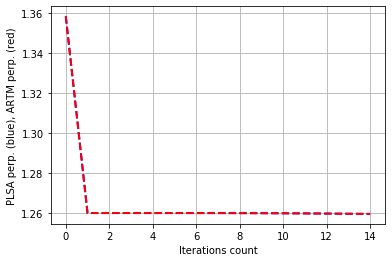

In [26]:
# adding scores crhecking and plot
def print_measures(model_plsa, model_artm):
    print('Sparsity Phi: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['SparsityPhiScore'].last_value,
        model_artm.score_tracker['SparsityPhiScore'].last_value))

    print('Sparsity Theta: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['SparsityThetaScore'].last_value,
        model_artm.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_contrast,
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_purity,
        model_artm.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['PerplexityScore'].last_value,
        model_artm.score_tracker['PerplexityScore'].last_value))

    plt.plot(range(model_plsa.num_phi_updates),
             model_plsa.score_tracker['PerplexityScore'].value, 'b--',
             range(model_artm.num_phi_updates),
             model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('PLSA perp. (blue), ARTM perp. (red)')
    plt.grid(True)
    plt.show()


# printing results
print_measures(model_plsa, model_artm)

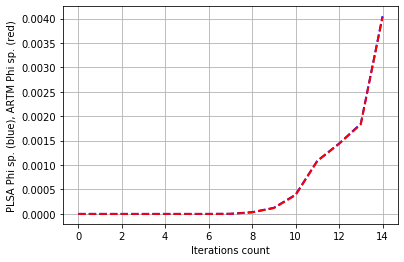

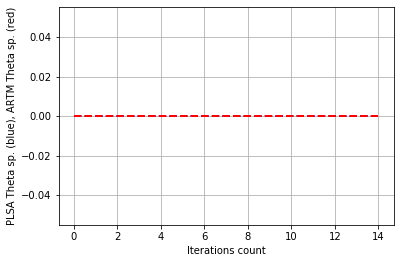

In [27]:
plt.plot(range(model_plsa.num_phi_updates),
         model_plsa.score_tracker['SparsityPhiScore'].value, 'b--',
         range(model_artm.num_phi_updates),
         model_artm.score_tracker['SparsityPhiScore'].value, 'r--', linewidth=2)

plt.xlabel('Iterations count')
plt.ylabel('PLSA Phi sp. (blue), ARTM Phi sp. (red)')
plt.grid(True)
plt.show()

plt.plot(range(model_plsa.num_phi_updates),
         model_plsa.score_tracker['SparsityThetaScore'].value, 'b--',
         range(model_artm.num_phi_updates),
         model_artm.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)

plt.xlabel('Iterations count')
plt.ylabel('PLSA Theta sp. (blue), ARTM Theta sp. (red)')
plt.grid(True)
plt.show()